<a href="https://colab.research.google.com/github/cedriclemercier/nlp-ablation-t5/blob/master/NLP_Testing_and_scoring_STOPWORDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install rouge_score
!pip install transformers

     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 212 kB 44.1 MB/s 
     |████████████████████████████████| 1.1 MB 41.9 MB/s 
     |████████████████████████████████| 136 kB 46.5 MB/s 
     |████████████████████████████████| 127 kB 45.7 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 45.3 MB/s 
     |████████████████████████████████| 144 kB 45.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 5.3 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import json

from datasets import load_dataset
from datasets import load_metric

from rouge_score import rouge_scorer
from transformers import T5Tokenizer, T5ForConditionalGeneration, tokenization_utils_base, AutoTokenizer, AutoModelForSeq2SeqLM


device = 'cuda'

In [ ]:
#Downloading 1000 sample sub dataset with less than 512 tokens dervied from the Xsum test dataset
!gdown --id 1JNJGv9de4MmQEWQ9hpd7KvU8y4akQ2eG

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1JNJGv9de4MmQEWQ9hpd7KvU8y4akQ2eG
To: /content/test_set.txt
100% 1.52M/1.52M [00:00<00:00, 145MB/s]


In [ ]:
with open('test_set.txt') as json_file:
    test_set = json.load(json_file)

# 2. Scorers

In [ ]:
def compute_metrics(predictions, actuals, tokenizer):
    
    # <your code here>
    metric = load_metric("rouge")
    result = metric.compute(predictions=predictions, references=actuals, use_stemmer=True)
    
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    rouge = {k: round(v, 4) for k, v in result.items()}

    return rouge

# 3. Model

In [ ]:
# let's define model parameters specific to BART
model_params = {
    "MODEL": "gniemiec/t5-small-finetuned-xsum",
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 36,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

In [ ]:
#Load the model

torch.manual_seed(model_params["SEED"])  # pytorch random seed
np.random.seed(model_params["SEED"])  # numpy random seed

tokenizer = AutoTokenizer.from_pretrained(model_params["MODEL"])

model = AutoModelForSeq2SeqLM.from_pretrained(model_params["MODEL"])

print(f"Loaded {model_params['MODEL']}")

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Loaded gniemiec/t5-small-finetuned-xsum


# 4. Test 1 sample

In [ ]:
model.eval()

with torch.no_grad():
    
    # tokens = tokenizer(test_set['document'][1], return_tensors="pt")
    tokens = tokenizer.batch_encode_plus([test_set['document'][0]], 
                                         max_length=model_params["MAX_SOURCE_TEXT_LENGTH"], 
                                         truncation=True, 
                                         padding="max_length", return_tensors="pt").to(device)
    # outputs = model.generate(tokens)
    outputs = model.to(device).generate(
                      input_ids = tokens.input_ids,
                      attention_mask = tokens.attention_mask, 
                      max_length=150, 
                      num_beams=2,
                      repetition_penalty=2.5, 
                      length_penalty=1.0, 
                      early_stopping=True
                      )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(decoded)

Police have recovered three firearms, ammunition and a five-figure sum of money.


In [ ]:
rouge = compute_metrics([decoded], [test_set['summary'][0]], tokenizer)   
rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
rouge_df

,0
rouge1,33.3333
rouge2,14.2857
rougeL,20.0000
rougeLsum,20.0000
gen_len,1.0000


# 5. Test on 1000 samples

In [ ]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix} | {iteration}/{total}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [ ]:
model.eval()
model = model.to(device)
predictions = []

l = len(test_set['document'])
printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
with torch.no_grad():
    for idx, doc in enumerate(test_set['document']):
        printProgressBar(idx + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        tokens = tokenizer.batch_encode_plus([doc], 
                                             max_length=model_params["MAX_SOURCE_TEXT_LENGTH"], 
                                             truncation=True, 
                                             padding="max_length", 
                                             return_tensors="pt").to(device)
       
        outputs = model.generate(
                      input_ids = tokens.input_ids,
                      attention_mask = tokens.attention_mask, 
                      max_length=150, 
                      num_beams=2,
                      repetition_penalty=2.5, 
                      length_penalty=1.0, 
                      early_stopping=True
                      )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded)

KeyboardInterrupt: ignored

# 5.01 Import dataset with STOPWORDS filtered 

In [ ]:
with open('ORG_filtered.txt') as json_file:
    summaries = json.load(json_file)

In [ ]:
summaries

# 5.02 Test 1000 filtered samples

In [ ]:
model.eval()
model = model.to(device)
predictions = []

l = len(summaries)
printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
with torch.no_grad():
    for idx, doc in enumerate(summaries):
        printProgressBar(idx + 1, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
        tokens = tokenizer.batch_encode_plus([doc], 
                                             max_length=model_params["MAX_SOURCE_TEXT_LENGTH"], 
                                             truncation=True, 
                                             padding="max_length", 
                                             return_tensors="pt").to(device)
       
        outputs = model.generate(
                      input_ids = tokens.input_ids,
                      attention_mask = tokens.attention_mask, 
                      max_length=150, 
                      num_beams=2,
                      repetition_penalty=2.5, 
                      length_penalty=1.0, 
                      early_stopping=True
                      )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(decoded)

Progress: |██████████████████████████████████████████████████| 100.0% Complete | 1000/1000


# 5.1 Saving results

In [ ]:
def save_results(predictions, actuals, output):
    df = pd.DataFrame({'predictions': predictions, 'actuals': actuals})
    df.to_csv(output)
    print("PREDICTIONS RESULTS SAVED.")

In [ ]:
save_results(predictions, test_set['summary'], 'outputs/predictions_ORG_filtered.csv')

PREDICTIONS RESULTS SAVED.


# 6.0 Evaluate

In [ ]:
#Download the predicted files directly
#!gdown --id 1UAtcrbShmETZJZ53mfCknvXFVOvU5jpD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1UAtcrbShmETZJZ53mfCknvXFVOvU5jpD
To: /content/predictions_stopwords_filtered.csv
100% 223k/223k [00:00<00:00, 88.8MB/s]


In [ ]:
predictions = pd.read_csv('predictions_stopwords_filtered.csv')

In [ ]:
preds = predictions['predictions'].tolist()

In [ ]:
preds[0:5]

['Police said three firearms, ammunition five-figure sum money recovered.',
 "''Senior decency?'' Prosecutors say suspects face two counts of hate crimes.",
 'West Brom have been appointed youth academy director 2000 director football since 2003.',
 'BT dodged bullet - chief executive Ofcom, Sharon White, admitted.',
 "'s, difficult achieve,'' said Rodgers."]

### First Rouge Score

In [ ]:
rouge = compute_metrics(preds, test_set['summary'], tokenizer)

In [ ]:
# ROUGE FOR STOPWORD FILTERED
rouge

{'gen_len': 1.0,
 'rouge1': 14.4311,
 'rouge2': 2.2165,
 'rougeL': 11.2318,
 'rougeLsum': 11.2154}

### Second Rouge Score

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge

rouge = Rouge()

In [ ]:
rouge.get_scores(preds, test_set['summary'], avg=True)

{'rouge-1': {'f': 0.11054732142419943,
  'p': 0.1394441966689495,
  'r': 0.09893821151713932},
 'rouge-2': {'f': 0.014562328960254181,
  'p': 0.019417352664340953,
  'r': 0.012842293487532188},
 'rouge-l': {'f': 0.09214027959018703,
  'p': 0.117144144483802,
  'r': 0.082306180871969}}

### BERT Score

In [ ]:
!pip install bert_score

     |████████████████████████████████| 60 kB 3.1 MB/s 


In [ ]:
from bert_score import BERTScorer
from bert_score import plot_example

In [ ]:
scorer = BERTScorer(lang="en", rescale_with_baseline=True)
P, R, F1 = scorer.score(preds, test_set['summary'])

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print("BERTScore")
print("R:",R.mean())
print("P:",P.mean())
print("F1:",F1.mean())

BERTScore
R: tensor(0.1190)
P: tensor(0.1041)
F1: tensor(0.1120)


### Similarity Matrix

In [ ]:
# plot_example(preds[0], test_set['summary'][0], lang="en")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


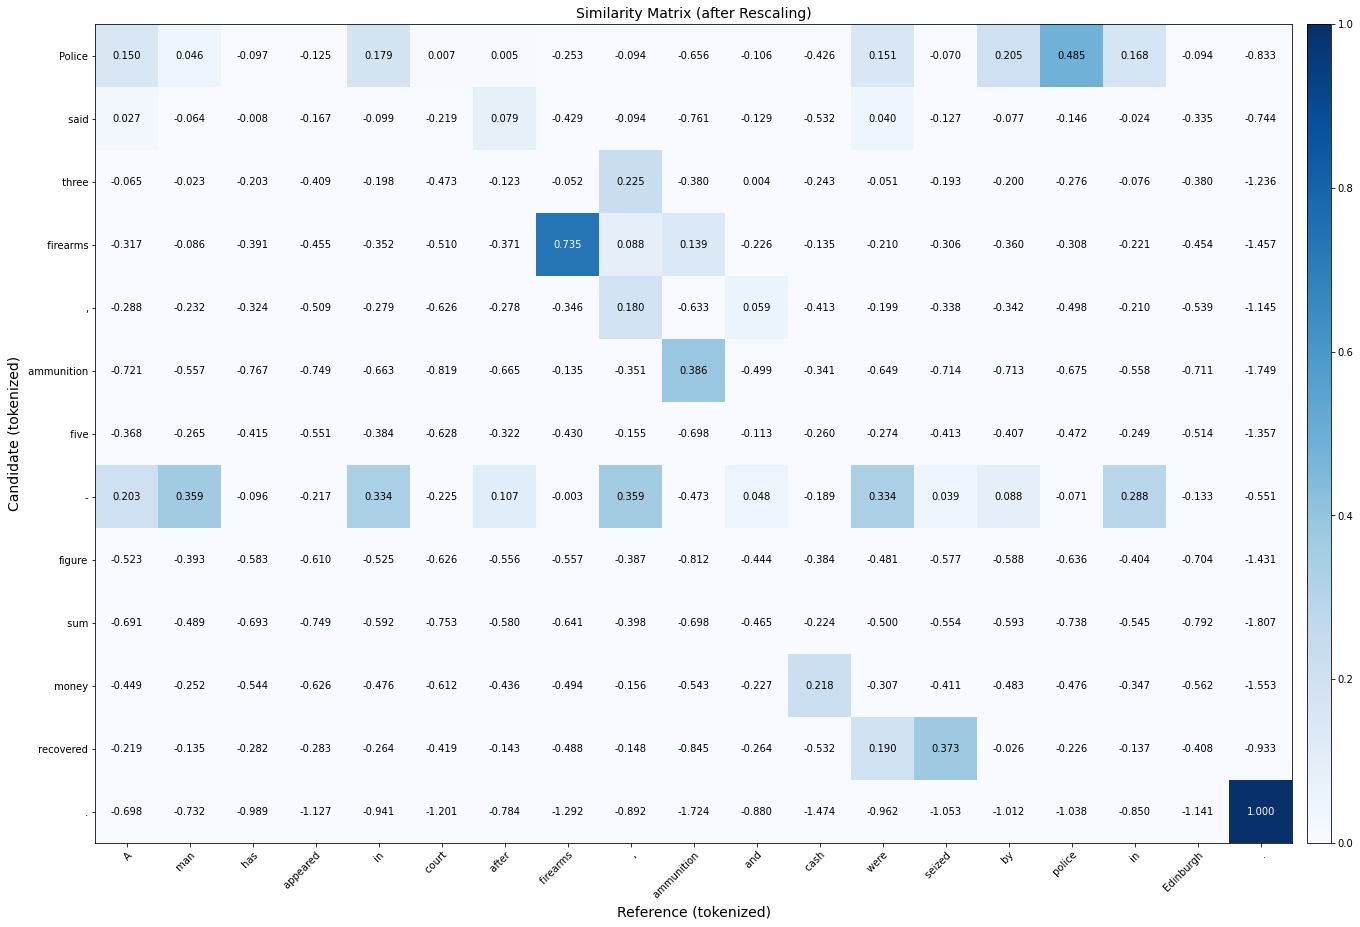

In [ ]:
plot_example(preds[0], test_set['summary'][0], lang="en", rescale_with_baseline=True)